In [1]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

In [3]:
df = pd.read_csv('data.csv',encoding='ISO-8859-1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df.dropna(subset=['CustomerID'])

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
df = df.copy() 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

In [13]:

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month_name()
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

df = df[df['Quantity'] > 0]

In [20]:
momthly_saless = df.groupby('InvoiceMonth')['TotalSales'].sum().reset_index()
top_products =df.groupby('Description')['Quantity'].sum().nlargest().reset_index()

In [22]:
customer_analysis = df.groupby('CustomerID').agg(
    TotalOrders=('InvoiceNo', 'nunique'),
    TotalSpent=('TotalSales', 'sum'),
    FirstPurchase=('InvoiceDate', 'min'),
    LastPurchase=('InvoiceDate', 'max')
).reset_index()


df['Profit'] = df['TotalSales'] * 0.25  # افتراض هامش ربح 25%
product_profit = df.groupby('Description').agg(
    TotalProfit=('Profit', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    TotalQuantity=('Quantity', 'sum')
).reset_index()

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Year,Month,DayOfWeek,Hour,InvoiceMonth,Profit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,December,Wednesday,8,2010-12,3.825
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8,2010-12,5.085
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,December,Wednesday,8,2010-12,5.500
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8,2010-12,5.085
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8,2010-12,5.085


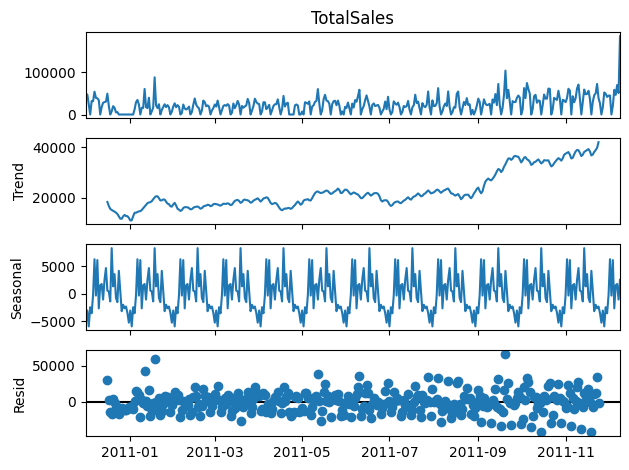

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose


daily_sales = df.resample('D', on='InvoiceDate')['TotalSales'].sum()


result = seasonal_decompose(daily_sales, model='additive', period=30)
result.plot()
plt.savefig('seasonal_analysis.png')

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# تحضير البيانات الشهرية
monthly = df.resample('M', on='InvoiceDate')['TotalSales'].sum()

# تقسيم البيانات
train = monthly[:'2011-06-30']
test = monthly['2011-07-31':]

# بناء النموذج
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# التنبؤ
forecast = model_fit.forecast(steps=len(test))

C:\Users\wleed\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wleed\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [34]:
df.to_csv('ecommerce_clean.csv', index=False)